In [62]:
from models import MNISTModel
from train_nvidia_model import fit, History
import torchvision
import torch
from torch.utils.data import Dataset, DataLoader
import random
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from dataclasses import dataclass, field

In [64]:
@dataclass 
class ActivationMapHook:
    activation: dict = field(default_factory=dict)
    
    def get_activation(self, name):
        def hook(model, input, output):
            self.activation[name] = output.detach()
        return hook

    def __getitem__(self, idx):
        return self.activation[idx]
    
    def __setitem__(self, idx, new_value):
        self.activation[idx] = new_value

In [34]:
%matplotlib inline

In [2]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [3]:
dev = torch.device("cpu")

In [4]:
data_train = torchvision.datasets.MNIST("mnist_data", train=True, download=True, transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

In [5]:
# big_train_ds, small_train_ds, valid_ds = torch.utils.data.random_split(data_train, [45000, 10000, 5000])
small_train_ds, valid_ds = torch.utils.data.random_split(data_train, [55000, 5000])

In [6]:
test_ds = torchvision.datasets.MNIST("mnist_data", train=False, download=True, transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

In [7]:
batch_size = 16
train_dl = DataLoader(small_train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [13]:
model = MNISTModel()
opt = torch.optim.AdamW(model.parameters(), lr=3e-4)
loss = torch.nn.NLLLoss()

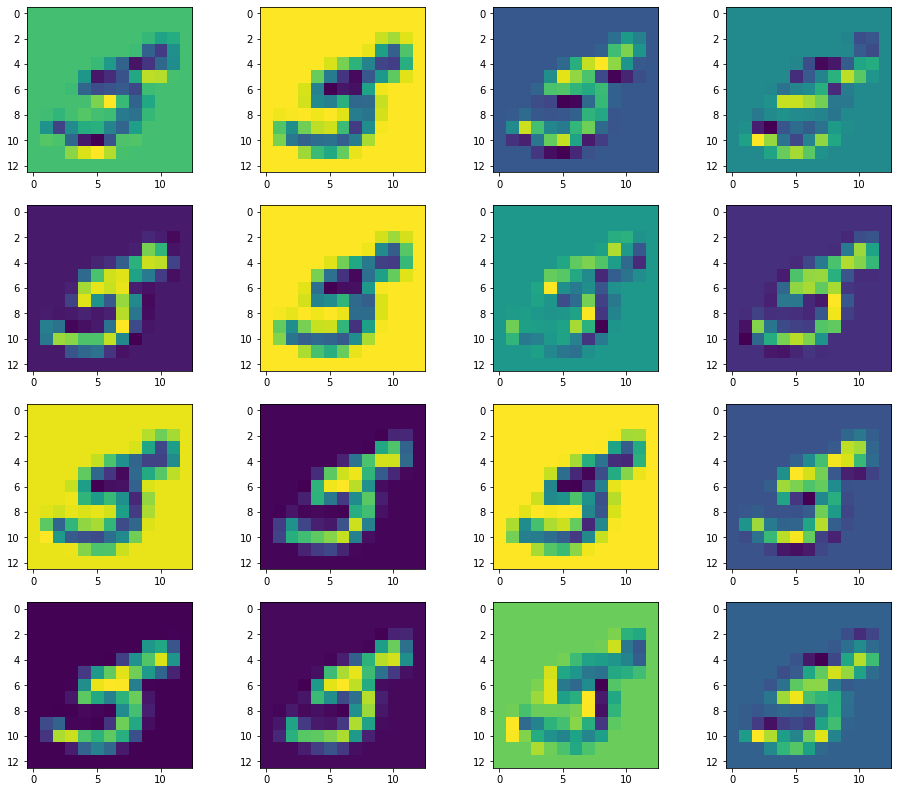

In [75]:
activation = ActivationMapHook()

model.cnn[0].register_forward_hook(activation.get_activation('cnn[0]'))
model.cnn[1].register_forward_hook(activation.get_activation('cnn[1]'))
data, y = small_train_ds[2]
data.unsqueeze_(0)
output = model(data)

act = activation['cnn[0]'].squeeze()
fig, axarr = plt.subplots(act.size(0) // 4, act.size(0) // 4, figsize=(16, 14))
for i in range(act.size(0) // 4):
    for j in range(4):
        axarr[i, j].imshow(act[i * 4 + j])

In [72]:
r:torch.Tensor = model(data)

In [ ]:
r.backward()

In [70]:
y

5

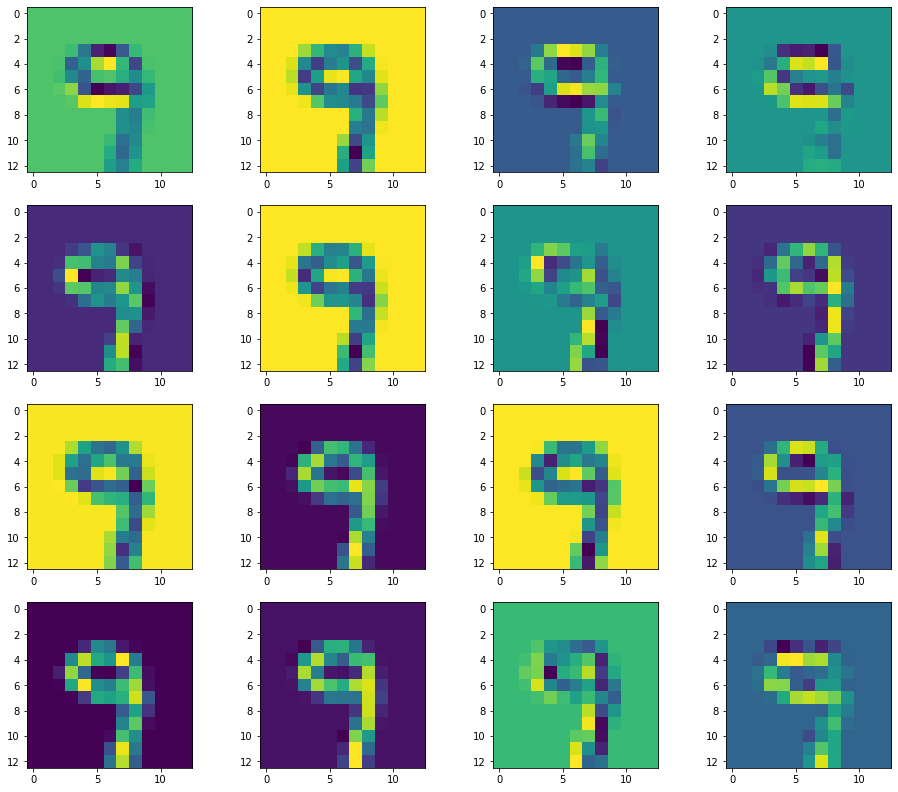

In [43]:
# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook 

model.cnn[0].register_forward_hook(get_activation('cnn[0]'))
data, _ = small_train_ds[0]
data.unsqueeze_(0)
output = model(data)

act = activation['cnn[0]'].squeeze()
fig, axarr = plt.subplots(act.size(0) // 4, act.size(0) // 4, figsize=(16, 14))
for i in range(act.size(0) // 4):
    for j in range(4):
        axarr[i, j].imshow(act[i * 4 + j])

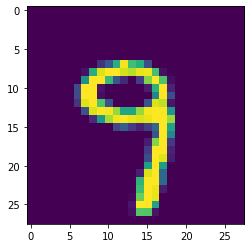

In [56]:
plt.imshow(data.squeeze(0).permute(1, 2, 0))

In [59]:
model(data).argmax()

tensor(9)

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import utils

def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

In [27]:
filters = model.cnn[2].weight.data.detach()

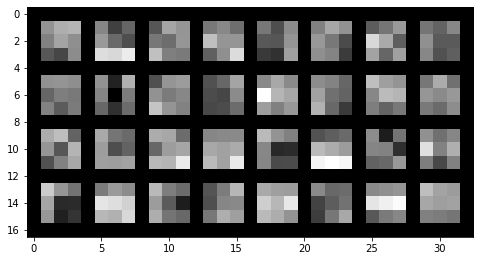

In [28]:
visTensor(filters)

In [10]:
# scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, [5], 0.1)

In [14]:
epochs = 15
history = History("prova", [0, 1, 2, 3], model, opt, loss, None, batch_size)
fit(epochs, history, [train_dl], [valid_dl], dev)

Start epoch #0...
Train_loss: 0.541308829141205
Valid_loss: 0.16903956006765367
Epoch complete in 0m 38s

Start epoch #1...
Train_loss: 0.21400689109638332
Valid_loss: 0.10773740500956774
Epoch complete in 0m 42s

Start epoch #2...
Train_loss: 0.15829017639536072
Valid_loss: 0.08741685248501599
Epoch complete in 0m 37s

Start epoch #3...
Train_loss: 0.13075456647127867
Valid_loss: 0.07521167168654501
Epoch complete in 0m 39s

Start epoch #4...
Train_loss: 0.11515980390977452
Valid_loss: 0.065479386684997
Epoch complete in 0m 34s

Start epoch #5...
Train_loss: 0.10285798750250516
Valid_loss: 0.059742563906591384
Epoch complete in 0m 43s

Start epoch #6...
Train_loss: 0.09114804156234657
Valid_loss: 0.0575070248035714
Epoch complete in 0m 36s

Start epoch #7...
Train_loss: 0.08654573215920987
Valid_loss: 0.056248984531499444
Epoch complete in 0m 37s

Start epoch #8...
Train_loss: 0.08053004656060683
Valid_loss: 0.05336252520370763
Epoch complete in 0m 39s

Start epoch #9...
Train_loss: 0

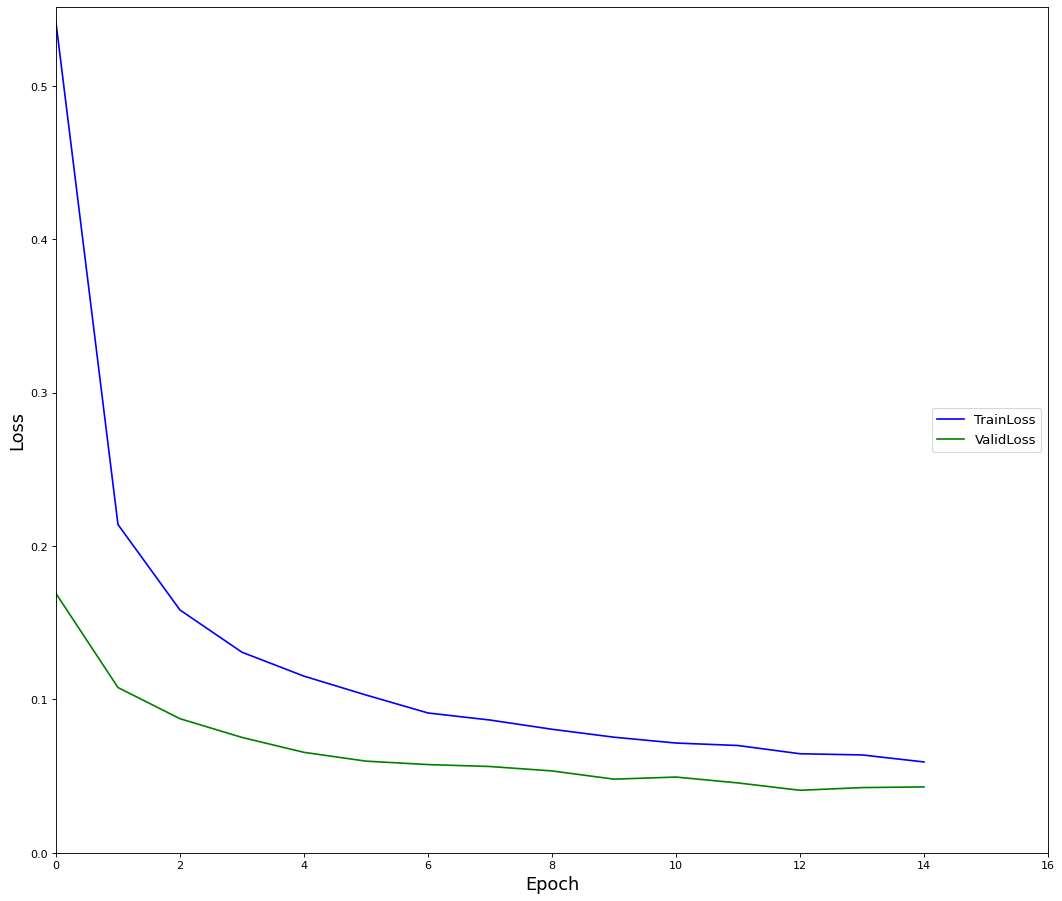

In [15]:
history.save_training_info()

In [16]:
def accuracy(model, test_dl):
    # return (preds == yb).float().mean()
    tot = 0
    correct = 0
    for x, y in test_dl:
        tot += y.shape[0]
        y_pred = model(x)
        preds = torch.argmax(y_pred, dim=1)
        correct += (preds == y).float().sum()
         
    print(f"accuracy: {correct / tot}")

In [17]:
accuracy(model, test_dl)

accuracy: 0.9897000193595886


In [18]:
test_losses = []

def test():
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_dl:
      output = model(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_dl.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_dl.dataset),
    100. * correct / len(test_dl.dataset)))

In [19]:
test()

C:\Users\Jest\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0317, Accuracy: 9897/10000 (99%)

